In [1]:
###### Relevant librairies ####
import numpy as np
import matplotlib.pyplot as plt
import string
import pandas as pd
import secrets
from scipy import linalg
import scipy.sparse.linalg as sla
import scipy.sparse as sparse 
import math
from numpy import random



In [2]:
### Random walk function ###
def BiasedRandomWalk(L=10, q=0.6, s0=5, maxstep=1000):
    """Produces trajectories of biased random walk:
    --- inputs:
    "L" denotes the size of the 1D line, which goes from 0 to L included.
    "q" denotes probability to go left
    "s0" is the initial position of the walker
    "maxstep" gives maximum time of trajectory (set to -1 for no limits)
    ---- returns:
    "traj_s": trajectory of states of length T+1 - s0, s1, s2, s3, ..., sT+1
    "traj_a": trajectory of actions (-1/+1) of length T - a0, a1, a2, a3, ..., aT
    "traj_r": trajectory of rewards (0/+1/-1) of length T - r0, r1, r2, r3, ..., rT
    """
    
    # Error check
    assert ((s0>0) and (s0<L)), "Error: s0 is not inside 0 and L!"
    assert ((q>=0) and (q<=1)), "Error: q must be a probability in [0,1]!"
    
    # Initialize Walker
    s = s0
    
    # Set status to not found
    done = False
    
    traj_s = [s0]
    traj_r = []
    traj_a = []
    
    # Time counter for avoiding too long trajs
    t = 0
    T =[t]
    
    # Run Proper simulation
    while ((done == False) and (t != maxstep)):
        # Choose action
        r = np.random.rand()
        
        if (r<q):
            s -= 1
            traj_a.append(-1)
        else:
            s += 1
            traj_a.append(+1)
        
        # Check if hits the wall
        if (s == 0):
            # Hits left wall: reward is -1
            rew = -1
            done = True
        elif (s == L):
            # Hits right wall: reward is +1
            rew = +1
            done = True
        else:
            # Still not done
            rew = 0
            done = False
        
        traj_s.append(s)
        traj_r.append(rew)
        
        # Increase time counter
        t += 1
        T.append(t)
        
    return traj_s, traj_r, traj_a, T
        

In [3]:
n_episodes = int(input("Enter the number of episodes "))
States = []
TS=[]
TR = []
G = []
#s0 = int(input("Enter a value of state S0 you want "))
for s0 in range (1,20):
    States.append(s0) 
    for episode in range(n_episodes):
        ts, tr, ta, T = BiasedRandomWalk(L=20, q=0.5, s0=s0)
        cumulative_reward = np.cumsum(tr)[-1] 
        if len(ts)>10:
            TS.append(ts[0:10])
            TR.append(tr[0:10])
            G.append(cumulative_reward)
print(States)
input_data = np.array(TS)
output_data = np.array(G)
print(input_data)
print(output_data)
print(len(input_data))
print(len(output_data))
print(len(input_data[1]))

Enter the number of episodes 1000
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[ 1  2  3 ...  4  3  4]
 [ 1  2  3 ...  4  3  2]
 [ 1  2  1 ...  4  3  2]
 ...
 [19 18 19 ... 16 17 16]
 [19 18 17 ... 16 17 18]
 [19 18 17 ... 18 19 18]]
[ 1 -1 -1 ... -1  1  1]
15122
15122
10


In [4]:
InputData1=input_data.T
InputData2=input_data.reshape((10,output_data.shape[0]))
#OutputData=output_data.reshape((1,output_data.shape[0]))
print(InputData1.shape)
print(InputData2.shape)

(10, 15122)
(10, 15122)


In [5]:
OutputData=output_data.reshape((1,output_data.shape[0]))
OutputData.shape

(1, 15122)

In [6]:
#####********************* Construction of the reservoir model**************************************** ###
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Preparing the data')
InputData=input_data.T
OutputData=output_data.reshape((1,output_data.shape[0]))
u = InputData


Preparing the data


In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Parameter of time')
T_out=[]
for i in np.arange(0,len(input_data)/1000,0.001):
    T_out.append(i)
T_out = np.array(T_out)
T_out = T_out.reshape((T_out.shape[0],1))


Parameter of time


In [8]:
print('Reservoir model building')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###  Initial the weights matrices ###   
np.random.seed(42)
LvlNoise = 10**-3   
N=1500 # nombres de neurones
K=10 # dimensions de l'entree
L= 1 # dimensions du retour
gamma = 0.01                            # connectivite
rho=0.79                              # Rayon specral
gainIn = 1    #  % Gain d'entrée
W=sparse.rand(N,N,gamma)
alpha=rho/max(abs((sla.eigs(W,k=1,M=None,sigma=None,which='LM')[0])))
W_rho=alpha*W
W=W_rho
W_in= 2*(np.random.rand(N,K)-0.5 )     # Masque d'entree
W_in = gainIn*W_in
W.data +=-0.5
W=W.todense()                           # connexion  internes
W_out= np.zeros((L,N))               # initialisation des poids de sorties
W_fb= 0 #2*(np.random.rand(N,L)-0.5 )    # poids de retour

Reservoir model building


In [9]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
####   Parameters of the reservoir   ####

T = len(T_out)
h=0.5    
delta=1
C= 0.44   #0.44          #  constante globale
a=0.9     #0.9           #  leak
#LvlNoise=0      # niveau de bruit
ridge=0         # methode d'inversion de la matrice de correlation
f_RC= 'np.tanh' # fonction du reservoir
transient = 1000   
trainEnd = 10000     
test84 = T     
fullTrain = 1

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###   Defining a sequence of training and a sequence of testing ###
A=transient
trainSeq=[]
for i in range (transient+1,trainEnd+1,1):
    A=A +1
    trainSeq.append(A)
trainSeq=np.array(trainSeq)
trainSeq=trainSeq.reshape((1,trainSeq.shape[0]))    # sequence d'apprentissage

B=trainEnd
libreSeq=[]
for i in range (trainEnd+1,T+1,1):
    B=B +1
    libreSeq.append(B)
libreSeq=np.array(libreSeq)
libreSeq=libreSeq.reshape((1,libreSeq.shape[0]))       # sequence d'evolution libre

In [11]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
### Relevant functions for training and testing ###

def feval(funcName, *args):                  ## fonction qui prend en argument funcName et args et resort la produit des deux
	return eval(funcName)(*args)


def majRes(f_RC,delta,leak,C,W_in,W,W_fb,x,u,y,bruit):   ## fonction qui defini l'etat du reservoir S
    
    x = (1 - delta*C*leak)*x + delta*C*feval(f_RC,W_in*u + W*x + W_fb*y + bruit)
    #S= np.vstack((x,u))  
    S=x.transpose()   #etat generalise du reservoir
    return  S

#----------------------------------------------------------------------
    
def calcPoidsSortie(S,y,ridge):   ## cette fonction permet de calculer le poids de sortie Wout par la formule 
    R= S.T.dot(S)   #correlation
    P= y.T.dot(S)    # corelation croisee
    W_out= P.dot(np.linalg.pinv(R))
    return W_out                        ## Wout = (yS.T)(SS.T)(pseudo inverse)

In [12]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print ('Training')

### Initialisation of the state function. ####

S=np.zeros((T,N))  #+K)) Change back to before
S[0:1,:]= (np.zeros((N,1))).T #np.vstack((np.zeros((N,1)),u[:,0:1])).T  # etat initial du reservoir


#### Training loop ######

for i in range(0,trainEnd):
    U=u[:,i:i+1].T
    S_1 = majRes(f_RC,delta,a,C,W_in,W,W_fb,S[i:i+1,0:N].T,U,OutputData[:,i:i+1],random.uniform(-LvlNoise,+LvlNoise,size=(N,1)))
    S[i]= S_1[-1]
print(f"shape_of_S ={S.shape}")

Training
shape_of_S =(15122, 1500)


In [13]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Calculating weight w_out')  
W_out = calcPoidsSortie(S[transient+1:trainEnd+1,:],OutputData[:,transient+1:trainEnd+1].T,ridge)


Calculating weight w_out


In [14]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Generating y_hat')
y_hat = np.concatenate((W_out.dot(S[0:transient,:].T),(W_out.dot(S[transient+1:trainEnd+1,:].T)),np.zeros((1,T-trainEnd))),axis=1)


Generating y_hat


In [15]:
Ending_point = []

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Prediction')

### Testing loop ################
for y in range(trainEnd,T):
    U=u[:,y:y+1].T
    F= U[0][-1]
    y_hat[:,y:y+1]= W_out.dot(S[y:y+1,:].T)
    S_2 = majRes(f_RC,delta,a,C,W_in,W,W_fb,S[y:y+1,0:N].T,U,y_hat[:,y:y+1],random.uniform(-LvlNoise,+LvlNoise,size=(N,1)))
    S[y:y+1,:]= S_2[-1]
    Ending_point.append([F])


Prediction


In [16]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Updating y_hat during the prediction')
y_hat[:,trainEnd:T]=W_out.dot(S[trainEnd:T,:].T)


Updating y_hat during the prediction


In [17]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
print('Printing y_hat (Reservoir output) and OutputData (Actual output)')
print(y_hat)
print(OutputData)


Printing y_hat (Reservoir output) and OutputData (Actual output)
[[-0.20873305  5.24051423  9.071644   ...  0.60748194  0.86234104
   0.82655563]]
[[ 1 -1 -1 ... -1  1  1]]


In [18]:
j=trainEnd
for i in range(len(Ending_point)):
    Ending_point[i].append(y_hat[:,j][0])
    j+=1
print(Ending_point)


[[13, 0.2977875228771154], [13, 0.08993749718138133], [17, 0.4679610414787021], [17, 0.7041371606519533], [15, 0.29822690701803367], [9, -0.30406407715963724], [11, 0.20988508368463954], [17, 0.7166086191955401], [7, -0.4523930043887958], [15, 0.3789904119530547], [15, 0.7167924892073643], [13, 0.2203571868049039], [9, -0.3439147463450354], [13, 0.3511663396311633], [13, 0.3791433584319748], [9, -0.011819392102552229], [13, 0.26471211806529027], [9, -0.3330342597218987], [9, 0.1369534005807509], [9, -0.10724838017085858], [13, 0.39175640129724343], [13, 0.38387376075115753], [14, 0.2723879449949891], [16, 0.48527375856792787], [10, 0.14746407124766847], [14, 0.34791881548881065], [14, 0.4404834497890988], [14, 0.46204025539191207], [10, 0.054615045666650985], [8, -0.45994141496885277], [8, -0.13934139893535757], [16, 0.3669246217541513], [12, -0.024410607480604085], [10, 0.05891143775806995], [14, 0.48105258029136166], [16, 0.5537226477335935], [8, -0.3024583182323113], [18, 0.93505307

In [19]:
### We associate
a={}
for i in Ending_point:
    a[i[0]]=[]
for i in Ending_point:
    a[i[0]].append(i[1])
a

{13: [0.2977875228771154,
  0.08993749718138133,
  0.2203571868049039,
  0.3511663396311633,
  0.3791433584319748,
  0.26471211806529027,
  0.39175640129724343,
  0.38387376075115753,
  0.18507600820703374,
  0.304421539820396,
  0.3185037402508897,
  0.3633630801377876,
  0.5470788785423792,
  0.31985396810523525,
  0.23351562829884642,
  0.11716752787287987,
  0.2593338152873912,
  0.3403453508581151,
  0.30049872915333253,
  0.42810287520478596,
  0.5649182917168218,
  0.42032940671560937,
  0.26644150768879626,
  0.17003133641446766,
  0.18969767581620545,
  0.36581940066389507,
  0.3880752289915108,
  0.2234115901937912,
  0.27412057033507153,
  0.23119805296664708,
  0.30185836969394586,
  0.2505003789119655,
  0.3490620361408219,
  0.22875750734419853,
  0.23279448073481035,
  0.4197424915182637,
  0.05962220271976548,
  0.3295965056768182,
  0.23563438591918384,
  0.24706094894645503,
  0.37985611777185113,
  0.33244748063043517,
  0.19728231211047387,
  0.39603621862261207,
  

[5, 5, 5, 5]
[-0.38749043252937554, -0.44455469942658965, 0.319631903194022, -0.3915831049598637]


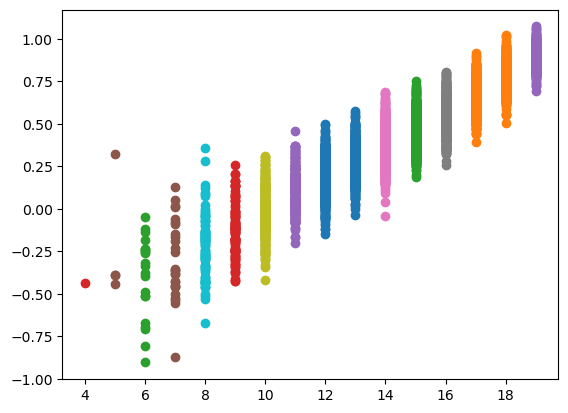

In [28]:
for i in a:
    length = len(a[i])
    x= [i]*length
    y=a[i]
    #z= -1+((i*length)/20)*2
    plt.scatter(x,y)
    #plt.scatter(x,z)
print(x)
print(y)